## 3.1. Randomizing our prediction
The first approach we're going to try is to randomize our character prediction. However, with an important detail: the random distribution we'll use will be given by the output of our RNN.

Our RNN outputs an array of floating point numbers compressed between 0 and 1, each one representing the probability of the character in that position of being the most suitable option for the prediction. However, currently we search for the most suitable one and select it as our result. What we're going to try now, instead, is to randomize our prediction while taking into account this probabilities. 

We'll achieve this by using the output array of our RNN as the [Probability Density Function](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_densidad_de_probabilidad) [1] for our randomized prediction. As this array contains the probability of each character, the sum of all its elements will always be 1 (because the probability of our prediction being a character, no matter which one, is 1). Let's see it with an example


We're going to load our last model and try to predict a random character, in order to see the output we get (the code is the same we've already used on previous notebooks, so don't worry about it)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

Using Theano backend.
Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN not available)


In [2]:
-

# Load the network weights
filename = "weights-improvement-03-1.4625.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
seed = ''.join([int_to_char[value] for value in pattern])
print "Seed:"
print "\"", seed, "\""
result_str = ""

Total Characters:  169841
Total Vocab:  53
Total Patterns:  169741
Seed:
" dole que en tal trance le socorriese, bien cubierto de su rodela, con
la lanza en el ristre, arremet "


Now, we'll use our model to generate a single prediction: we're not even going to learn a character for it, we simply want to check the output array

In [3]:
# Generate characters
x = np.reshape(pattern, (1, len(pattern), 1))
x = x / float(n_vocab)
prediction = model.predict(x, verbose=0)

In [4]:
print(prediction)

[[  7.59417389e-07   1.76937720e-05   2.40122433e-09   2.71557888e-23
    0.00000000e+00   0.00000000e+00   2.20720404e-22   2.35617244e-06
    3.10220355e-13   8.89342822e-09   1.09114922e-08   1.80561841e-08
    3.02201653e-10   3.48554319e-03   9.65453091e-06   4.06953099e-04
    6.18201797e-04   7.92584121e-02   1.85742834e-08   3.83133956e-05
    2.11823050e-07   8.29551995e-01   1.14979359e-08   4.38928138e-03
    3.62755905e-04   9.84037397e-05   3.10215503e-02   5.61233319e-05
    1.08083809e-08   7.22140321e-05   2.30366131e-05   2.30339239e-03
    2.71837780e-04   5.48295338e-06   3.95447980e-10   2.89058280e-05
    1.12288365e-06   1.06998628e-25   2.09331988e-23   4.96095576e-14
    6.36697317e-09   5.68675551e-10   1.12827107e-23   1.46414880e-08
    4.32056335e-11   2.75433565e-09   9.83110038e-10   4.03751739e-13
    9.33175989e-20   3.35577042e-18   7.21598434e-26   4.79756184e-02]]


As we can see, the array contains numbers between 0 and 1; each one represents the probability of the character in that position of being the correct character to output. However, this doesn't seem to be a very clear representation. Let's see it graphically.

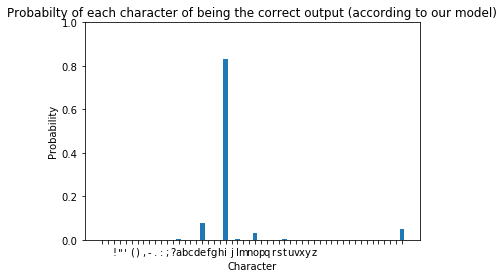

In [5]:
# Creating the indices array
indices = np.arange(len(prediction[0]))

# Creating the plots
fig, ax = plt.subplots()
preds = ax.bar(indices, prediction[0])

# Adding some text for labels and titles
ax.set_xlabel('Character')
ax.set_ylabel('Probability')
ax.set_title('Probabilty of each character of being the correct output (according to our model)')
ax.set_xticks(indices)
ax.set_xticklabels((c for c in chars if ord(c) < 0x81))  # We can't use non ascii chars as label
ax.set_ylim(top=1.0)
plt.show()

As we can see, our model seems quite convinced that the correct character to output is 'i' (and, watching the seed, I can tell you that it's probably correct: "arremetió" is a real word in Spanish, and it would make sense in that context). However, we cannot simply discard the other characters: although they may seem improbable, there may be cases where an improbable option is the correct one (or, what happens more often, that the decision is not so clear). Therefore, as we've said, we're going to choose the output randomly by using this distribution as the PDF. 

We'll generate a new array with the same length as the output one that contains the cummulative probability of the characters, i.e. each element will contain the probability of the correct output character to be at his position or a previous one. The result will be similar to the following one:

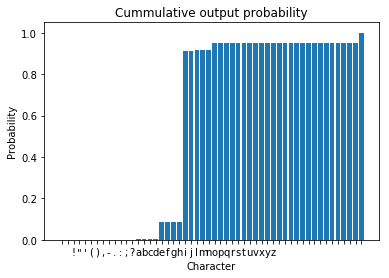

In [6]:
prob_cum = np.cumsum(prediction[0])

# Creating the indices array
indices = np.arange(len(prob_cum))

# Creating the plots
fig, ax = plt.subplots()
preds = ax.bar(indices, prob_cum)

# Adding some text for labels and titles
ax.set_xlabel('Character')
ax.set_ylabel('Probability')
ax.set_title('Cummulative output probability')
ax.set_xticks(indices)
ax.set_xticklabels((c for c in chars if ord(c) < 0x81))  # We can't use non ascii chars as label
plt.show()

As you can see the final value is 1, because it is sure that the output will be chosen from one of the characters in the array. 

In order to use that as the PDF, what we'll do is to generate a random number between 0 and 1 and choose the first element of the array to be greater than it. As you can imagine, the char that will appear the most is the 'i', because a lot of numbers between 0 and 1 are lower than prob_cum['i'] but greater than prob_cum['h']. However, we won't always output 'i', so our output will have some random component while keeping a plausible distribution. 

### 3.1.1. Testing the improvement
Now it's time to see if our improvement is really an improvement or not: we'll implement it in our predictions.

As the model and the libraries are already loaded we don't need to repeat that step, so we'll start directly by loading the weights and picking a random seed.

In [7]:
# Generate characters
for i in range(500):
	x = np.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
    
    # Choosing the character randomly
	prediction = model.predict(x, verbose=0)
	prob_cum = np.cumsum(prediction[0])
	rand_ind = np.random.rand()
	for i in range(len(prob_cum)):
	    if (rand_ind <= prob_cum[i]) and (rand_ind > prob_cum[i-1]):
	        index = np.argmax(prediction)
	        break
            
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	result_str += result
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print "\nDone."


Done.


In [8]:
print seed + result_str

dole que en tal trance le socorriese, bien cubierto de su rodela, con
la lanza en el ristre, arremetió a su harta en el camino de la mancha, estaba diciendo:

-ste que se dice esto se puede ser mandar al corral, y a los desemgañados que los cespabando lossrados y de la mancha, estaba diciendo:

-ste que se dice -dijo el cura-- y ellos mo había de ser que se había de serreros y enn quijote de la mancha, estaba diciendo::

-ste que es ma podía en el marmeno ee la mancha, estaba don quijote de la mancha, estaba diciendo:

-ste que se dice esto se puede ser mandar al corral, y a los d


Well, here we have some good news and some bad ones: as we can see, the model doesn't get stuck anymore (at least, not as much as before)! However, now the result looks a lot less than real text. This means that the predictions that it makes still aren't as good as we'd like them to be. Therefore, we'll keep training our network until we get results that look really readable.